100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05trial/s, best loss: -0.9373826990392493]
Best hyperparameters: {'C': 28.88099048032379, 'enn_n_neighbors': 2.0, 'penalty': 1, 'smote_k_neighbors': 3.0}
Balanced accuracy on the test set: 0.9070
Classification report on test set:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       575
           1       0.18      0.94      0.31        18

    accuracy                           0.87       593
   macro avg       0.59      0.91      0.62       593
weighted avg       0.97      0.87      0.91       593



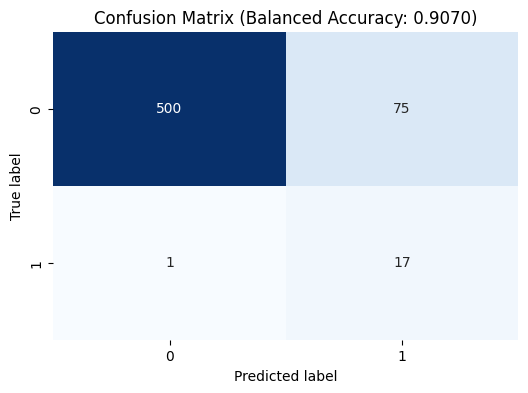

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Define a custom transformer for SMOTEENN that handles both X and y
class SMOTEENNWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, smote_k_neighbors=5, enn_n_neighbors=3):
        self.smote_k_neighbors = smote_k_neighbors
        self.enn_n_neighbors = enn_n_neighbors
        self.smote_enn = SMOTEENN(
            smote=SMOTE(k_neighbors=self.smote_k_neighbors),
            enn=EditedNearestNeighbours(n_neighbors=self.enn_n_neighbors)
        )

    def fit(self, X, y):
        # Resample both X and y, and store the resampled versions
        self.X_resampled, self.y_resampled = self.smote_enn.fit_resample(X, y)
        return self

    def transform(self, X):
        # Return the resampled X (this will be called during pipeline transform)
        return self.X_resampled

    def fit_transform(self, X, y):
        # Resample both X and y, and return the resampled X (as expected by pipeline)
        self.fit(X, y)
        return self.X_resampled

    def get_resampled_y(self):
        # Add a method to get resampled y for proper pipeline fit
        return self.y_resampled

def preprocess_and_apply_smoteenn_with_hyperopt():
    # Load the dataset
    data = pd.read_csv('../data_transformed6.csv')

    # Remove leading and trailing whitespace from column names
    data.columns = data.columns.str.strip()

    # Define the target variable (assuming it's called 'Bankrupt?' in the uploaded file)
    target_variable = 'Bankrupt?'

    # Separate features and target variable
    y = data[target_variable]
    X = data.drop(columns=[target_variable])

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the search space for hyperopt
    space = {
        'smote_k_neighbors': scope.int(hp.quniform('smote_k_neighbors', 2, 10, 1)),
        'enn_n_neighbors': scope.int(hp.quniform('enn_n_neighbors', 2, 10, 1)),
        'C': hp.loguniform('C', np.log(0.001), np.log(100)),
        'penalty': hp.choice('penalty', ['l1', 'l2'])
    }

    def objective(params):
        smote_enn = SMOTEENNWrapper(smote_k_neighbors=params['smote_k_neighbors'], enn_n_neighbors=params['enn_n_neighbors'])

        # Fit and resample X and y with SMOTEENNWrapper
        X_resampled = smote_enn.fit_transform(X_train, y_train)
        y_resampled = smote_enn.get_resampled_y()  # Get resampled y

        # Define a pipeline with Logistic Regression after resampling
        pipeline = Pipeline([
            ('classifier', LogisticRegression(solver='liblinear', C=params['C'], penalty=params['penalty'], random_state=42))
        ])

        # Perform 5-fold cross-validation with the resampled data
        score = cross_val_score(pipeline, X_resampled, y_resampled, cv=5, scoring='balanced_accuracy').mean()

        return {'loss': -score, 'status': STATUS_OK}

    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

    print("Best hyperparameters:", best)

    # Train the best model using the best hyperparameters found
    best_smote_k_neighbors = int(best['smote_k_neighbors'])
    best_enn_n_neighbors = int(best['enn_n_neighbors'])
    best_C = best['C']
    best_penalty = ['l1', 'l2'][best['penalty']]

    # Recreate the final model with the best parameters
    smote_enn = SMOTEENNWrapper(smote_k_neighbors=best_smote_k_neighbors, enn_n_neighbors=best_enn_n_neighbors)
    X_resampled = smote_enn.fit_transform(X_train, y_train)
    y_resampled = smote_enn.get_resampled_y()

    best_pipeline = Pipeline([
        ('classifier', LogisticRegression(solver='liblinear', C=best_C, penalty=best_penalty, random_state=42))
    ])

    # Fit the best model on the resampled training set
    best_pipeline.fit(X_resampled, y_resampled)

    # Test the model on the original test set
    y_pred = best_pipeline.predict(X_test)

    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced accuracy on the test set: {balanced_acc:.4f}")

    # Classification report
    print("Classification report on test set:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix (Balanced Accuracy: {balanced_acc:.4f})')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return best_pipeline

# Run the process
best_model = preprocess_and_apply_smoteenn_with_hyperopt()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:21<00:00,  2.44trial/s, best loss: -0.9309090909090909]
Best hyperparameters: {'C': 0.6284657088453562, 'kind_sel': 0, 'n_neighbors': 72.0, 'penalty': 0}
Balanced accuracy on the test set: 0.9313
Classification report on test set:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93       575
           1       0.19      1.00      0.31        18

    accuracy                           0.87       593
   macro avg       0.59      0.93      0.62       593
weighted avg       0.98      0.87      0.91       593



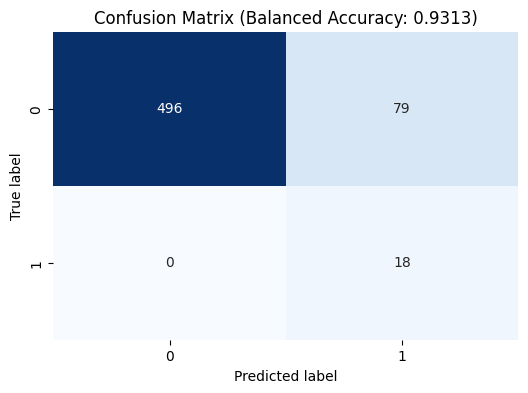

In [10]:
# 导入所需的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
import seaborn as sns

# 定义 RepeatedENN 的自定义 transformer
class RepeatedENNWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=3, kind_sel="all", max_iter=100):
        self.n_neighbors = n_neighbors
        self.kind_sel = kind_sel
        self.max_iter = max_iter  # 固定 max_iter 为 100
        self.repeated_enn = RepeatedEditedNearestNeighbours(
            n_neighbors=self.n_neighbors,
            max_iter=self.max_iter,
            kind_sel=self.kind_sel
        )

    def fit(self, X, y):
        self.X_resampled, self.y_resampled = self.repeated_enn.fit_resample(X, y)
        return self

    def transform(self, X):
        return self.X_resampled

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.X_resampled

    def get_resampled_y(self):
        return self.y_resampled

# 通用的预处理和应用函数，适用于 RepeatedENN
def preprocess_and_apply_repeatedenn_with_hyperopt():
    # 加载数据集
    data = pd.read_csv('../data_transformed6.csv')

    # 去除列名的首尾空格
    data.columns = data.columns.str.strip()

    # 定义目标变量
    target_variable = 'Bankrupt?'

    # 分离特征和目标变量
    y = data[target_variable]
    X = data.drop(columns=[target_variable])

    # 将数据集拆分为训练集和测试集（80%训练，20%测试）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 定义 hyperopt 的目标函数
    def objective(params):
        # 使用RepeatedENN进行数据重采样
        resampling = RepeatedENNWrapper(n_neighbors=params['n_neighbors'], kind_sel=params['kind_sel'])
        X_resampled = resampling.fit_transform(X_train, y_train)
        y_resampled = resampling.get_resampled_y()

        # 构建逻辑回归模型管道
        pipeline = Pipeline([
            ('classifier', LogisticRegression(solver='liblinear', C=params['C'], penalty=params['penalty'], random_state=42, max_iter=1000))
        ])

        # 使用交叉验证评估模型的平衡准确度
        score = cross_val_score(pipeline, X_resampled, y_resampled, cv=5, scoring='balanced_accuracy').mean()
        return {'loss': -score, 'status': STATUS_OK}

    # 超参数优化
    trials = Trials()
    space = {
        'n_neighbors': scope.int(hp.quniform('n_neighbors', 3, 80, 1)),
        'kind_sel': hp.choice('kind_sel', ['all', 'mode']),
        'C': hp.loguniform('C', np.log(0.001), np.log(100)),
        'penalty': hp.choice('penalty', ['l1', 'l2'])
    }

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=200,
                trials=trials)

    print("Best hyperparameters:", best)

    # 根据最佳参数重新训练模型
    best_n_neighbors = int(best['n_neighbors'])
    best_kind_sel = ['all', 'mode'][best['kind_sel']]
    best_C = best['C']
    best_penalty = ['l1', 'l2'][best['penalty']]

    # 使用最佳超参数重新采样数据
    resampling = RepeatedENNWrapper(n_neighbors=best_n_neighbors, kind_sel=best_kind_sel)
    X_resampled = resampling.fit_transform(X_train, y_train)
    y_resampled = resampling.get_resampled_y()

    # 使用最佳超参数重新构建逻辑回归模型管道
    best_pipeline = Pipeline([
        ('classifier', LogisticRegression(solver='liblinear', C=best_C, penalty=best_penalty, random_state=42))
    ])

    # 在重新采样后的训练集上拟合模型
    best_pipeline.fit(X_resampled, y_resampled)

    # 在测试集上评估模型
    y_pred = best_pipeline.predict(X_test)

    # 计算平衡准确度
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced accuracy on the test set: {balanced_acc:.4f}")

    # 打印分类报告
    print("Classification report on test set:")
    print(classification_report(y_test, y_pred))

    # 混淆矩阵
    conf_matrix = confusion_matrix(y_test, y_pred)

    # 可视化混淆矩阵
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix (Balanced Accuracy: {balanced_acc:.4f})')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return best_pipeline

# 运行 RepeatedENN
best_repeatedenn_model = preprocess_and_apply_repeatedenn_with_hyperopt()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:30<00:00,  1.65s/trial, best loss: -0.9440895682488604]
Best hyperparameters: {'C': 0.001681719352173784, 'n_neighbors': 70.0, 'penalty': 1}
Balanced accuracy on the test set: 0.8843
Classification report on test set:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       575
           1       0.12      1.00      0.21        18

    accuracy                           0.78       593
   macro avg       0.56      0.88      0.54       593
weighted avg       0.97      0.78      0.85       593



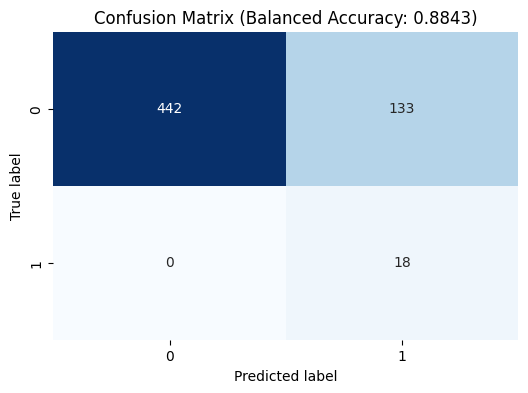

In [11]:
# 导入所需的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import AllKNN
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
import seaborn as sns

# 定义 AllKNN 的自定义 transformer
class AllKNNWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.all_knn = AllKNN(n_neighbors=self.n_neighbors)

    def fit(self, X, y):
        self.X_resampled, self.y_resampled = self.all_knn.fit_resample(X, y)
        return self

    def transform(self, X):
        return self.X_resampled

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.X_resampled

    def get_resampled_y(self):
        return self.y_resampled

# 通用的预处理和应用函数，适用于 AllKNN
def preprocess_and_apply_allknn_with_hyperopt():
    # 加载数据集
    data = pd.read_csv('../data_transformed6.csv')

    # 去除列名的首尾空格
    data.columns = data.columns.str.strip()

    # 定义目标变量
    target_variable = 'Bankrupt?'

    # 分离特征和目标变量
    y = data[target_variable]
    X = data.drop(columns=[target_variable])

    # 将数据集拆分为训练集和测试集（80%训练，20%测试）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 定义 hyperopt 的目标函数
    def objective(params):
        # 使用AllKNN进行数据重采样
        resampling = AllKNNWrapper(n_neighbors=params['n_neighbors'])
        X_resampled = resampling.fit_transform(X_train, y_train)
        y_resampled = resampling.get_resampled_y()

        # 构建逻辑回归模型管道
        pipeline = Pipeline([
            ('classifier',
             LogisticRegression(solver='liblinear', C=params['C'], penalty=params['penalty'], random_state=42,max_iter=1000))
        ])

        # 使用交叉验证评估模型的平衡准确度
        score = cross_val_score(pipeline, X_resampled, y_resampled, cv=5, scoring='balanced_accuracy').mean()
        return {'loss': -score, 'status': STATUS_OK}

    # 超参数优化
    trials = Trials()
    space = {
        'n_neighbors': scope.int(hp.quniform('n_neighbors', 2, 80, 1)),
        'C': hp.loguniform('C', np.log(0.001), np.log(100)),
        'penalty': hp.choice('penalty', ['l1', 'l2'])
    }

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=200,
                trials=trials)

    print("Best hyperparameters:", best)

    # 根据最佳参数重新训练模型
    best_n_neighbors = int(best['n_neighbors'])
    best_C = best['C']
    best_penalty = ['l1', 'l2'][best['penalty']]

    # 使用最佳超参数重新采样数据
    resampling = AllKNNWrapper(n_neighbors=best_n_neighbors)
    X_resampled = resampling.fit_transform(X_train, y_train)
    y_resampled = resampling.get_resampled_y()

    # 使用最佳超参数重新构建逻辑回归模型管道
    best_pipeline = Pipeline([
        ('classifier', LogisticRegression(solver='liblinear', C=best_C, penalty=best_penalty, random_state=42,max_iter=1000))
    ])

    # 在重新采样后的训练集上拟合模型
    best_pipeline.fit(X_resampled, y_resampled)

    # 在测试集上评估模型
    y_pred = best_pipeline.predict(X_test)

    # 计算平衡准确度
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced accuracy on the test set: {balanced_acc:.4f}")

    # 打印分类报告
    print("Classification report on test set:")
    print(classification_report(y_test, y_pred))

    # 混淆矩阵
    conf_matrix = confusion_matrix(y_test, y_pred)

    # 可视化混淆矩阵
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix (Balanced Accuracy: {balanced_acc:.4f})')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return best_pipeline

# 运行 AllKNN
best_allknn_model = preprocess_and_apply_allknn_with_hyperopt()
